***
# __Imports__
***

In [1]:
from statistics import mean

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import KFold, cross_val_predict, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from aqmd_pylib.aqmd_lib import data_toolkit as dtk
from aqmd_pylib.aqmd_lib.util import nLoop
from aqmd_pylib.aqmd_lib import util

***
# __Settings__
***

In [2]:
RANDOM_STATE = 42
SAVE_FIGURES = True
LOAD_FROM_MEMORY = False
USE_SCALED = False
PARALLEL_CORES = -1  # "-1" will use all cores available

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

***
# __Variables and Filepaths
__
***

In [3]:
site='Iowa'
site_filename='iowa'
traffic_feature='TrafficDensity'
traffic_filename='trafficDensity'
traffic_FolderName='traffic_density'

y_var='PM2.5'
y_fileLabel='pm25'
y_units='[ug/m3]'

filepath_site_pollutant = f'../data/complete_sets/{site_filename}/{site_filename}_full_{y_fileLabel}_{traffic_feature}.csv'
filepath_site_x = f'../data/complete_sets/{site_filename}_{y_fileLabel}_{traffic_feature}_x.csv'
filepath_site_y = f'../data/complete_sets/{site_filename}_{y_fileLabel}_{traffic_feature}_y.csv'
filepath_site_train_x = f'../data/complete_sets/train/{y_fileLabel}_{traffic_feature}_train_x.csv'
filepath_site_train_y = f'../data/complete_sets/train/{y_fileLabel}_{traffic_feature}_train_y.csv'
filepath_site_test_x = f'../data/complete_sets/test/{y_fileLabel}_{traffic_feature}_test_x.csv'
filepath_site_test_y = f'../data/complete_sets/test/{y_fileLabel}_{traffic_feature}_test_y.csv'

FolderPath_graphs = f'../graphs/{y_fileLabel}/{traffic_FolderName}'

datetime_format='%Y-%m-%d %H:%M:%S%z'

y_colLabel = f'{site} {y_var} {y_units}'
continuous_variables = [
    'Temperature [degC]',
    'Pressure [mbar]',
    'Humidity [%]',
    'Wind Speed [mph]',
    'Wind Direction [degrees]',
    f'Background {y_var} {y_units}',
    'Density Local 1 (#Vehicles/mile)',
    'Density Local 2 (#Vehicles/mile)',
    'Density Local 9 (#Vehicles/mile)',
    'Density Local 10 (#Vehicles/mile)',
    'Density Fwy 1 (#Vehicles/mile)',
    'Density Fwy 4 (#Vehicles/mile)'
]
feat_filenames = ['year', 'month', 'day', 'dayofweek_01_Sunday', 'dayofweek_02_Monday', 'dayofweek_03_Tuesday',
                  'dayofweek_04_Wednesday', 'dayofweek_05_Thursday', 'dayofweek_06_Friday', 'dayofweek_07_Saturday',
                  'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'background_pm25', f'{traffic_filename}',
                  f'{traffic_filename}_local2', f'{traffic_filename}_local9', f'{traffic_filename}_local10', f'{traffic_filename}_fwy1', f'{traffic_filename}']

***
# __Load Data__
***

In [4]:
if ~LOAD_FROM_MEMORY:
    site_pollutant = pd.read_csv(filepath_site_pollutant)
    site_pollutant = dtk.df_str2dt(site_pollutant, 'datetime-America/Los_Angeles',
                              datetime_format, curr_tz='America/Los_Angeles', overwrite=True)
    site_pollutant.set_index('datetime-America/Los_Angeles', inplace=True)
    print(dtk.df_getColNames(site_pollutant))
    site_scaled = site_pollutant.copy()
    for feat in continuous_variables:
        site_scaled[feat] = StandardScaler().fit_transform(site_scaled.loc[:, [feat]])
    if USE_SCALED:
        site_x = site_scaled.drop(columns=y_colLabel)
    else:
        site_x = site_pollutant.drop(columns=y_colLabel)
    site_y = site_pollutant.loc[:, y_colLabel]
    site_train_x, site_test_x, site_train_y, site_test_y = train_test_split(
        site_x, site_y,
        test_size=0.2,
        random_state=RANDOM_STATE
    )
    site_x.to_csv(filepath_site_x)
    site_y.to_csv(filepath_site_y)
    site_train_x.to_csv(filepath_site_train_x)
    site_train_y.to_csv(filepath_site_train_y)
    site_test_x.to_csv(filepath_site_test_x)
    site_test_y.to_csv(filepath_site_test_y)
else:
    site_x=pd.read_csv(filepath_site_x)
    site_x=dtk.df_str2dt(site_x,'datetime-America/Los_Angeles',datetime_format)
    site_y=pd.read_csv(filepath_site_y)
    site_y=dtk.df_str2dt(site_y,'datetime-America/Los_Angeles',datetime_format)
    site_train_x = pd.read_csv(filepath_site_train_x)
    site_train_x=dtk.df_str2dt(site_train_x,'datetime-America/Los_Angeles',datetime_format)
    site_train_y = pd.read_csv(filepath_site_train_y)
    site_train_y=dtk.df_str2dt(site_train_y,'datetime-America/Los_Angeles',datetime_format)
    site_test_x = pd.read_csv(filepath_site_test_x)
    site_test_x=dtk.df_str2dt(site_test_x,'datetime-America/Los_Angeles',datetime_format)
    site_test_y = pd.read_csv(filepath_site_test_y)
    site_test_y=dtk.df_str2dt(site_test_y,'datetime-America/Los_Angeles',datetime_format)

['Iowa PM2.5 [ug/m3]', 'year', 'month', 'day', 'dayofweek_Sunday', 'dayofweek_Monday', 'dayofweek_Tuesday', 'dayofweek_Wednesday', 'dayofweek_Thursday', 'dayofweek_Friday', 'dayofweek_Saturday', 'Temperature [degC]', 'Pressure [mbar]', 'Humidity [%]', 'Wind Speed [mph]', 'Wind Direction [degrees]', 'Background PM2.5 [ug/m3]', 'Density Local 1 (#Vehicles/mile)', 'Density Local 2 (#Vehicles/mile)', 'Density Local 9 (#Vehicles/mile)', 'Density Local 10 (#Vehicles/mile)', 'Density Fwy 1 (#Vehicles/mile)', 'Density Fwy 4 (#Vehicles/mile)']


***
# __Gradient Boosted Regression Model__
***

***
> ## __Model Parameters__
***

In [5]:
gbt_model_params = {
    'loss'                    : 'huber',
    'learning_rate'           : 0.001,
    'verbose'                 : True,
    'n_estimators'            : 9000,
    'subsample'               : 1.0,
    'criterion'               : 'friedman_mse',
    'min_samples_split'       : 2,
    'min_samples_leaf'        : 2,
    'min_weight_fraction_leaf': 0.0,
    'max_depth'               : 4,
    'min_impurity_decrease'   : 0.0,
    'init'                    : None,
    'random_state'            : RANDOM_STATE,
    'max_features'            : 'auto',
    'alpha'                   : 0.9,
    'max_leaf_nodes'          : None,
    'warm_start'              : False,
    'validation_fraction'     : 0.1,
    'n_iter_no_change'        : 100

}

***
> ## __Cross Validation - Model Evaluation__
***

In [6]:
gbt_model_cv = GradientBoostingRegressor(**gbt_model_params)
cv_split = KFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)
cv_results = cross_validate(gbt_model_cv,
                            X=site_x,
                            y=site_y,
                            n_jobs=PARALLEL_CORES,
                            cv=cv_split,
                            scoring=(
                                'r2', 'explained_variance', 'neg_mean_squared_error', 'neg_root_mean_squared_error'),
                            return_train_score=True,
                            verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.7min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished


In [7]:
print(cv_results.keys())
score_cols = ['Fit Time:', 'Score Time:', 'Avg. Test R2:', 'Avg. Test MSE:', 'Avg. Test RMSE:',
              'Avg. Test Explained Variance:',
              'Avg. Train R2:', 'Avg. Train MSE:', 'Avg. Train RMSE:', 'Avg. Train Explained Variance:']

score_matrix = [[mean(cv_results['fit_time']), mean(cv_results['score_time']), mean(cv_results['test_r2']),
                 abs(mean(cv_results['test_neg_mean_squared_error'])),
                 abs(mean(cv_results['test_neg_root_mean_squared_error'])),
                 mean(cv_results['test_explained_variance']), mean(cv_results['train_r2']),
                 abs(mean(cv_results['train_neg_mean_squared_error'])),
                 abs(mean(cv_results['train_neg_root_mean_squared_error'])),
                 mean(cv_results['train_explained_variance'])]]
print(
    f'\nCross Validation Results:\n'
    f'  Fit Time: {mean(cv_results["fit_time"])}\n'
    f'  Score Time: {mean(cv_results["score_time"])}\n'
    f'  Test R2: {mean(cv_results["test_r2"])}\n'
    f'  Train R2: {mean(cv_results["train_r2"])}\n'
    f'  Test MSE: {abs(mean(cv_results["test_neg_mean_squared_error"]))}\n'
    f'  Train MSE: {abs(mean(cv_results["train_neg_mean_squared_error"]))}\n'
    f'  Test RMSE: {abs(mean(cv_results["test_neg_root_mean_squared_error"]))}\n'
    f'  Train RMSE: {abs(mean(cv_results["train_neg_root_mean_squared_error"]))}\n'
    f'  Test Explained Variance: {mean(cv_results["test_explained_variance"])}\n'
    f'  Train Explained Variance: {mean(cv_results["train_explained_variance"])}\n'
)
score_table = pd.DataFrame(data=score_matrix, columns=score_cols).melt(var_name='Cross Validation Metric',
                                                                       value_name='Score Results')
score_table['Score Results'] = score_table['Score Results'].apply(lambda x: round(x, 4))

dict_keys(['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_explained_variance', 'train_explained_variance', 'test_neg_mean_squared_error', 'train_neg_mean_squared_error', 'test_neg_root_mean_squared_error', 'train_neg_root_mean_squared_error'])

Cross Validation Results:
  Fit Time: 221.50750169754028
  Score Time: 0.11185979843139648
  Test R2: 0.9185497584992462
  Train R2: 0.9440689965977807
  Test MSE: 1.9167679726217028
  Train MSE: 1.3183992007155325
  Test RMSE: 1.3821587670193092
  Train RMSE: 1.1476223670635908
  Test Explained Variance: 0.918754586972027
  Train Explained Variance: 0.9441655128053426



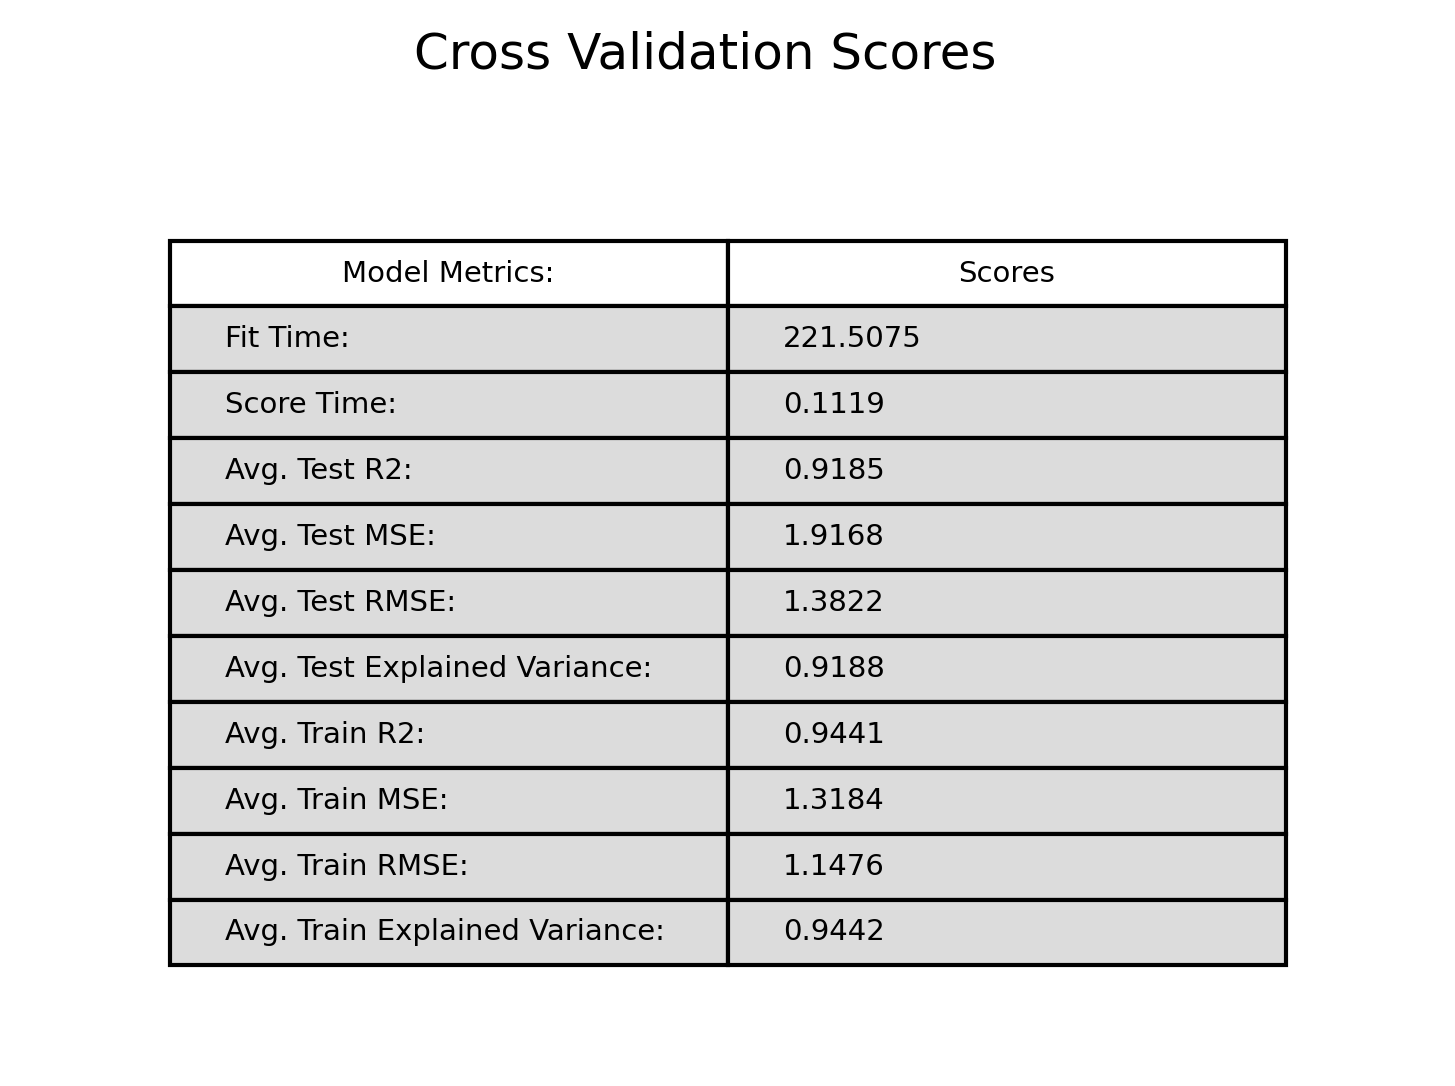

In [8]:

score_fig, score_ax = plt.subplots(dpi=300)
score_fig.suptitle('Cross Validation Scores')
color_matrix = np.full((10, 2), fill_value='gainsboro')
score_ax.set_axis_off()
score_ax.table(cellColours=color_matrix, cellText=score_table.values, cellLoc='left',
               colLabels=['Model Metrics:', 'Scores'], bbox=[0.1, 0.1, 0.8, 0.8])
if SAVE_FIGURES:
    score_fig.savefig(FolderPath_graphs + '/cross_validation_scores.png', dpi=300)

In [9]:
gbt_model_cvp = GradientBoostingRegressor(**gbt_model_params)

In [10]:
cv_y = cross_val_predict(gbt_model_cvp,
                         X=site_x,
                         y=site_y,
                         cv=cv_split,
                         n_jobs=PARALLEL_CORES,
                         verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.7min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min finished


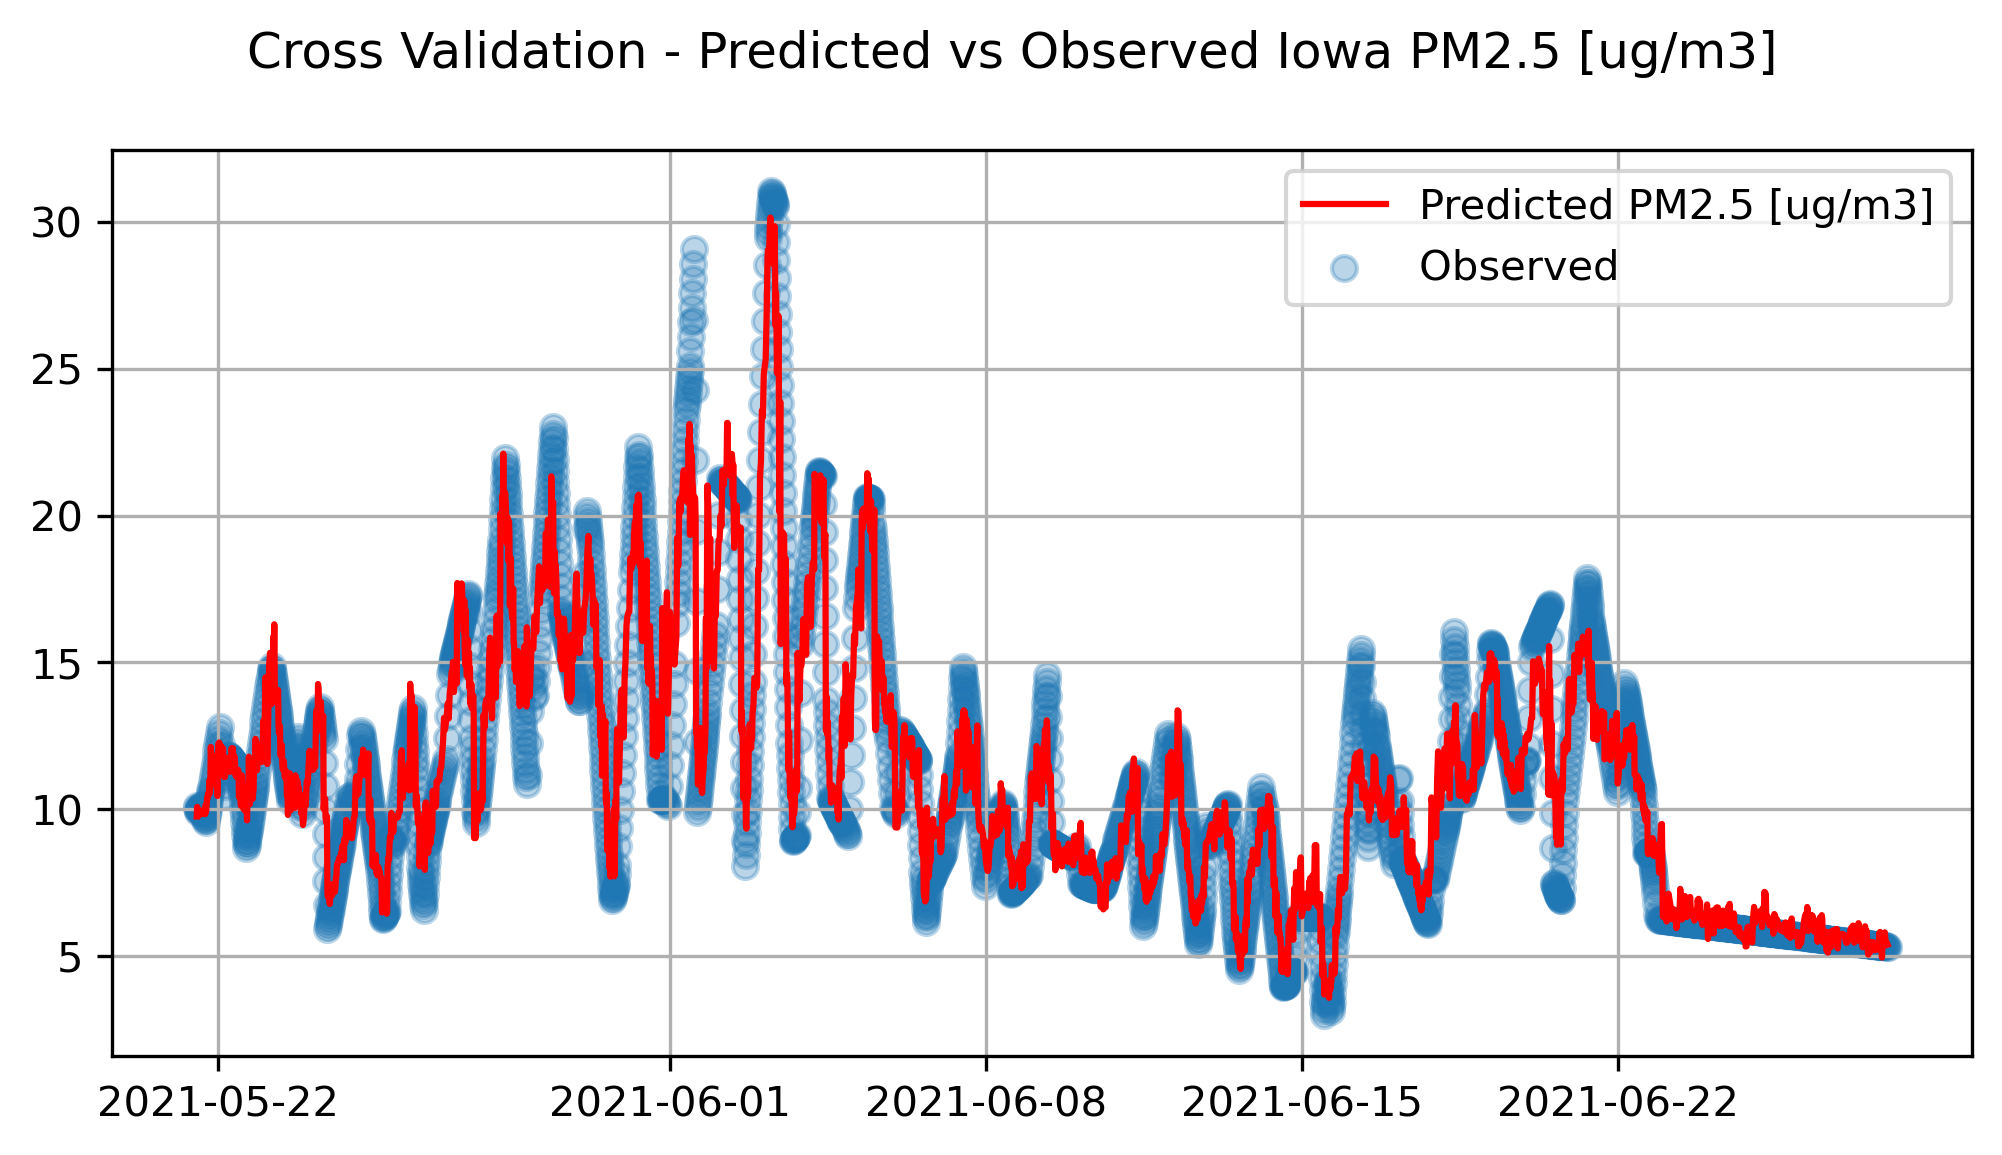

In [11]:
cv_fig, cv_ax = plt.subplots(dpi=300, figsize=(8, 4))
cv_site = pd.concat([site_x, site_y], axis=1)
cv_site[f'Predicted {site} {y_var} {y_units}'] = cv_y
cv_site.sort_index(inplace=True)
cv_site.reset_index(inplace=True)
cv_ax.scatter(
    cv_site.loc[:, 'datetime-America/Los_Angeles'],
    cv_site.loc[:, f'{site} {y_var} {y_units}'],
    label=f'Observed ',
    alpha=0.3
)
cv_ax.plot(
    cv_site.loc[:, 'datetime-America/Los_Angeles'],
    cv_site.loc[:, f'Predicted {site} {y_var} {y_units}'],
    label=f'Predicted {y_var} {y_units}',
    color='red'
)
cv_fig.suptitle(f'Cross Validation - Predicted vs Observed {site} {y_var} {y_units}')
cv_ax.legend()
cv_ax.grid()
if SAVE_FIGURES:
    cv_fig.savefig(FolderPath_graphs + f'/cross_validation_{y_fileLabel}.png', dpi=300)

***
> ## __Leave One Out - Model Evaluation__
***

In [12]:
gbt_model_loo = GradientBoostingRegressor(**gbt_model_params)
gbt_model_loo.fit(X=site_train_x, y=site_train_y)
iowa_test_predY = gbt_model_loo.predict(site_test_x)

      Iter       Train Loss   Remaining Time 
         1          11.0906            2.51m
         2          11.0746            2.67m
         3          11.0586            2.58m
         4          11.0427            2.53m
         5          11.0268            2.50m
         6          11.0109            2.46m
         7          10.9951            2.47m
         8          10.9793            2.48m
         9          10.9636            2.50m
        10          10.9478            2.46m


C:\Users\Alex\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


        20          10.7899            2.59m
        30          10.6369            2.76m
        40          10.4949            2.78m
        50          10.3511            2.71m
        60          10.2195            2.65m
        70          10.0880            2.60m
        80           9.9549            2.56m
        90           9.8255            2.53m
       100           9.6986            2.52m
       200           8.5630            2.53m
       300           7.6080            2.57m
       400           6.7972            2.50m
       500           6.0897            2.37m
       600           5.4689            2.27m
       700           4.9072            2.33m
       800           4.4734            2.38m
       900           4.1106            2.37m
      1000           3.8143            2.33m
      2000           1.9384            2.02m
      3000           1.3414            1.76m
      4000           1.0367            1.46m
      5000           0.8706            1.15m
      6000

In [13]:
iowa_test = pd.concat([site_test_x, site_test_y], axis=1)
iowa_test[f'pred {site} {y_var} {y_units}'] = iowa_test_predY
iowa_test.sort_index(inplace=True)
iowa_test.reset_index(inplace=True)
iowa_test.info()
iowa_test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype                                 
---  ------                             --------------  -----                                 
 0   datetime-America/Los_Angeles       599 non-null    datetime64[ns, pytz.FixedOffset(-420)]
 1   year                               599 non-null    int64                                 
 2   month                              599 non-null    int64                                 
 3   day                                599 non-null    int64                                 
 4   dayofweek_Sunday                   599 non-null    int64                                 
 5   dayofweek_Monday                   599 non-null    int64                                 
 6   dayofweek_Tuesday                  599 non-null    int64                                 
 7   dayofweek_Wednesday                

datetime-America/Los_Angeles  year  month  day  dayofweek_Sunday  \
0      2021-05-21 12:30:00-07:00  2021      5   21                 0   
1      2021-05-21 14:15:00-07:00  2021      5   21                 0   
2      2021-05-21 16:00:00-07:00  2021      5   21                 0   
3      2021-05-21 19:45:00-07:00  2021      5   21                 0   
4      2021-05-21 20:00:00-07:00  2021      5   21                 0   
..                           ...   ...    ...  ...               ...   
594    2021-06-27 17:15:00-07:00  2021      6   27                 1   
595    2021-06-27 17:30:00-07:00  2021      6   27                 1   
596    2021-06-27 17:45:00-07:00  2021      6   27                 1   
597    2021-06-27 19:45:00-07:00  2021      6   27                 1   
598    2021-06-27 22:00:00-07:00  2021      6   27                 1   

     dayofweek_Monday  dayofweek_Tuesday  dayofweek_Wednesday  \
0                   0                  0                    0   
1                   0                  0                    0   
2                   0                  0                    0   
3                   0                  0                    0   
4                   0                  0                    0   
..                ...                ...                  ...   
594                 0                  0                    0   
595                 0                  0                    0   
596                 0                  0                    0   
597                 0                  0                    0   
598                 0                  0                    0   

     dayofweek_Thursday  dayofweek_Friday  dayofweek_Saturday  \
0                     0                 1                   0   
1                     0                 1                   0   
2                     0                 1                   0   
3                     0                 1                   0   
4                     0                 1                   0   
..                  ...               ...                 ...   
594                   0                 0                   0   
595                   0                 0                   0   
596                   0                 0                   0   
597                   0                 0                   0   
598                   0                 0                   0   

     Temperature [degC]  Pressure [mbar]  Humidity [%]  Wind Speed [mph]  \
0                 19.91             1015            30              2.68   
1                 21.65             1014            27              3.58   
2                 21.84             1013            29              3.58   
3                 17.43             1014            45              3.13   
4                 15.76             1016            54              1.79   
..                  ...              ...           ...               ...   
594               33.84             1004            40              2.24   
595               33.84             1004            40              2.24   
596               33.84             1004            40              2.24   
597               30.81             1005            45              1.79   
598               24.69             1006            62              1.34   

     Wind Direction [degrees]  Background PM2.5 [ug/m3]  \
0                         260                      -1.0   
1                         179                       5.0   
2                         190                       1.0   
3                         284                       6.0   
4                         261                       5.0   
..                        ...                       ...   
594                       171                      11.0   
595                       171                      11.0   
596                       171                      11.0   
597                       281                      11.0   
598            

In [14]:
print(
    f'\nLeave One Out Results:\n'
    f'  R2: {metrics.r2_score(site_test_y, iowa_test_predY)}\n'
    f'  MSE:{metrics.mean_squared_error(site_test_y, iowa_test_predY, squared=True)}\n'
    f'  RMSE: {metrics.mean_squared_error(site_test_y, iowa_test_predY, squared=False)}\n'
    f'  Explained Variance {metrics.explained_variance_score(site_test_y, iowa_test_predY)}\n'
)


Leave One Out Results:
  R2: 0.9178026291445648
  MSE:1.8821303971342442
  RMSE: 1.3719075760175115
  Explained Variance 0.9178537002642448



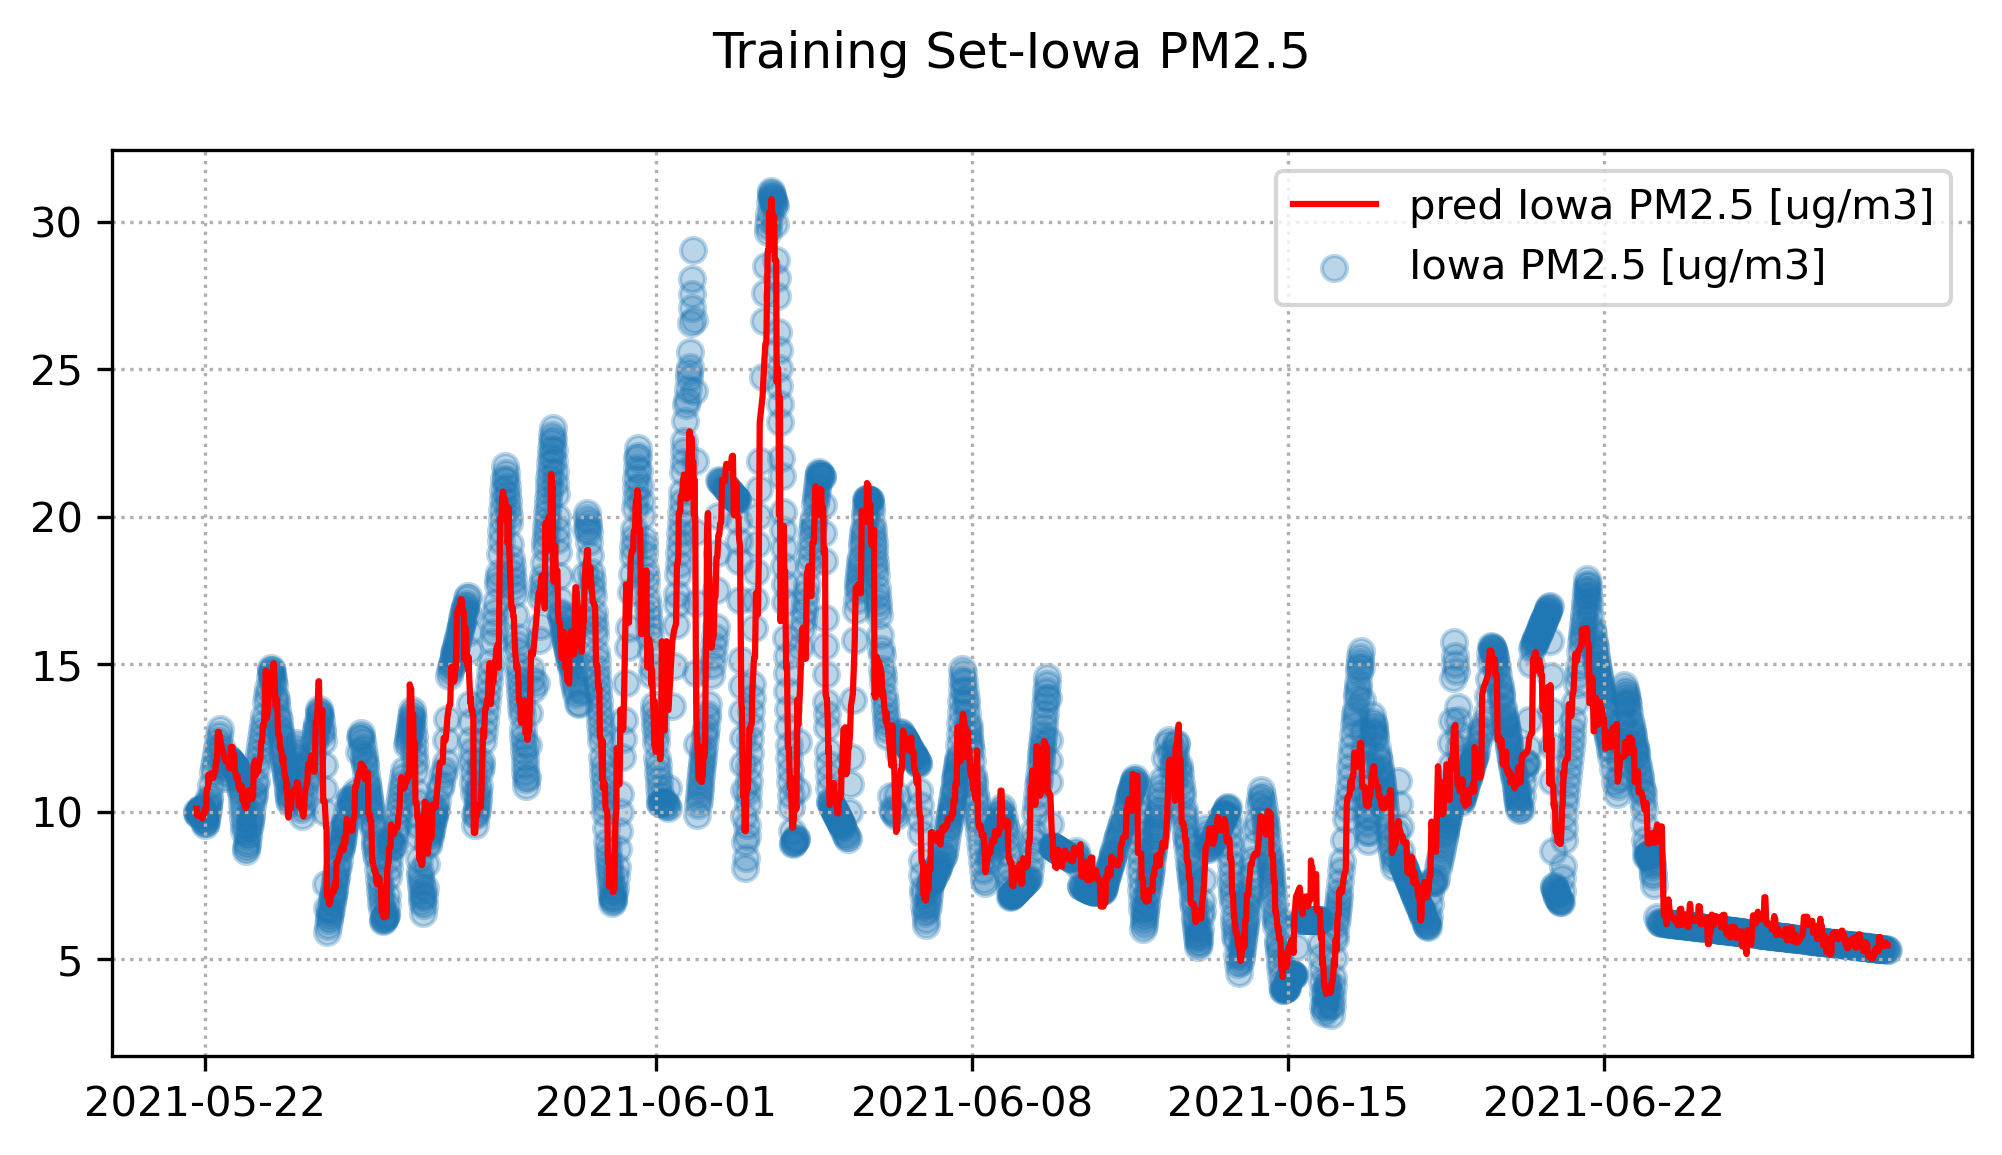

In [15]:
train_fig, train_ax = plt.subplots(dpi=300, figsize=(8, 4))
site_train_x.sort_index(inplace=True)
train_ax.plot(
    site_train_x.index.values,
    gbt_model_loo.predict(site_train_x),
    color='red',
    label=f'pred {site} {y_var} {y_units}'
)
train_ax.scatter(
    site_train_y.index.values,
    site_train_y,
    alpha=0.3,
    label=f'{site} {y_var} {y_units}'
)
train_fig.suptitle(f'Training Set-{site} {y_var}')
train_ax.grid(linestyle=':')
train_ax.legend()
if SAVE_FIGURES:
    train_fig.savefig(FolderPath_graphs + f'/{y_var}_Training_Data.png', dpi=300)

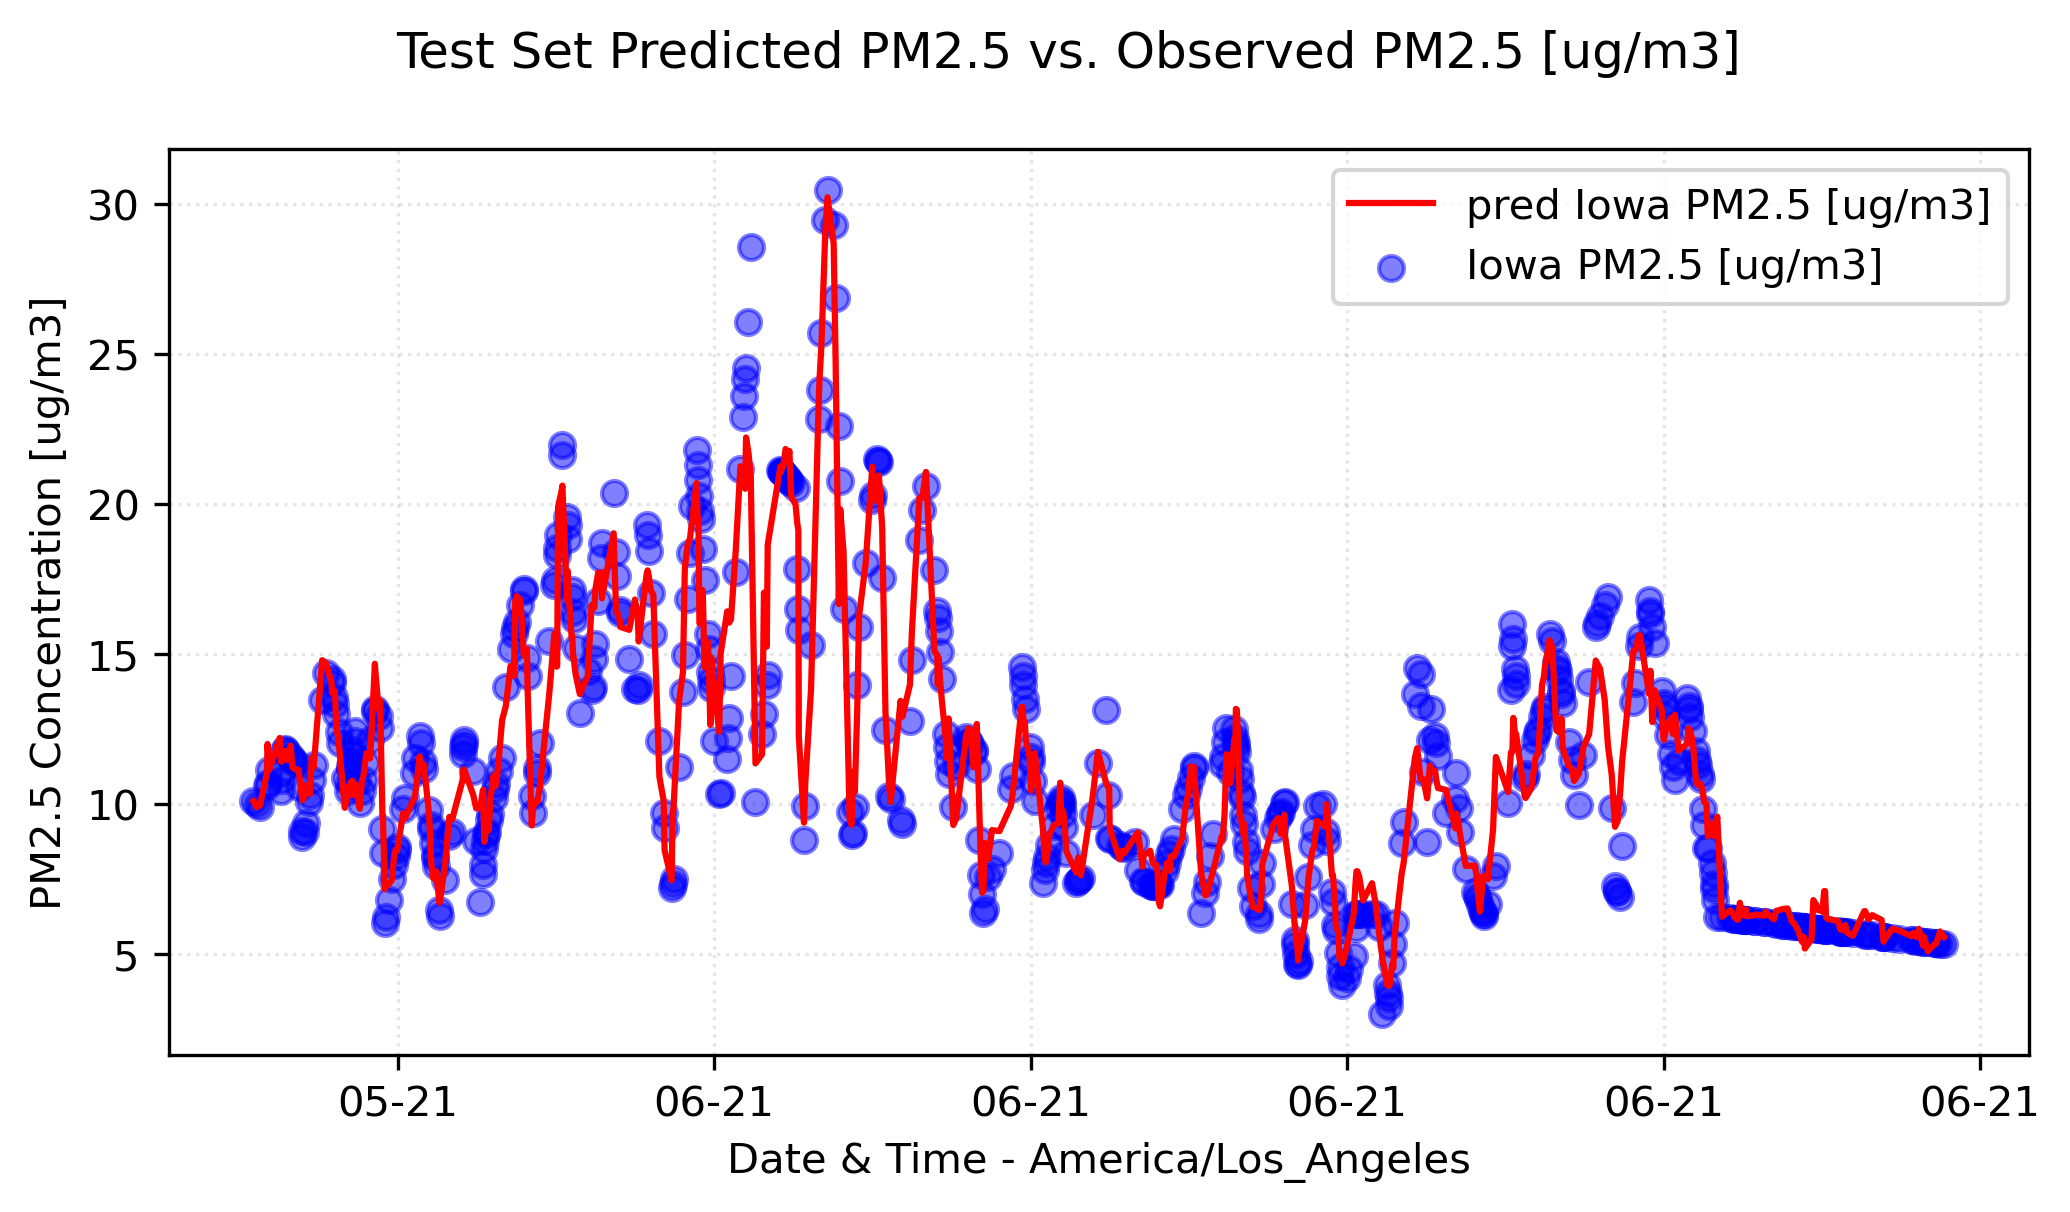

In [16]:
valid_fig, valid_ax = plt.subplots(dpi=300, figsize=(8, 4))
valid_ax.plot(
    iowa_test.loc[:, 'datetime-America/Los_Angeles'],
    iowa_test.loc[:, f'pred {site} {y_var} {y_units}'],
    color='red',
    label=f'pred {site} {y_var} {y_units}'
)
valid_ax.scatter(
    iowa_test.loc[:, 'datetime-America/Los_Angeles'],
    iowa_test.loc[:, f'{site} {y_var} {y_units}'],
    alpha=0.5,
    color='blue',
    label=f'{site} {y_var} {y_units}'
)
valid_ax.set_ylabel(f'{y_var} Concentration {y_units}')
valid_ax.set_xlabel('Date & Time - America/Los_Angeles')
valid_ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=1))
valid_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))
valid_ax.grid(axis='both', alpha=0.1, color='black', linestyle=':')
valid_fig.suptitle(f'Test Set Predicted {y_var} vs. Observed {y_var} {y_units}')
valid_ax.legend()
if SAVE_FIGURES:
    valid_fig.savefig(FolderPath_graphs + f'/{site}_Test_Evaluation.png', dpi=300)

***
# __Partial Dependence__
***

In [17]:
print(dtk.df_getColNames(site_train_x))
site_train_x

['year', 'month', 'day', 'dayofweek_Sunday', 'dayofweek_Monday', 'dayofweek_Tuesday', 'dayofweek_Wednesday', 'dayofweek_Thursday', 'dayofweek_Friday', 'dayofweek_Saturday', 'Temperature [degC]', 'Pressure [mbar]', 'Humidity [%]', 'Wind Speed [mph]', 'Wind Direction [degrees]', 'Background PM2.5 [ug/m3]', 'Density Local 1 (#Vehicles/mile)', 'Density Local 2 (#Vehicles/mile)', 'Density Local 9 (#Vehicles/mile)', 'Density Local 10 (#Vehicles/mile)', 'Density Fwy 1 (#Vehicles/mile)', 'Density Fwy 4 (#Vehicles/mile)']


year  month  day  dayofweek_Sunday  \
datetime-America/Los_Angeles                                       
2021-05-21 12:45:00-07:00     2021      5   21                 0   
2021-05-21 13:00:00-07:00     2021      5   21                 0   
2021-05-21 13:15:00-07:00     2021      5   21                 0   
2021-05-21 13:30:00-07:00     2021      5   21                 0   
2021-05-21 13:45:00-07:00     2021      5   21                 0   
...                            ...    ...  ...               ...   
2021-06-27 21:00:00-07:00     2021      6   27                 1   
2021-06-27 21:30:00-07:00     2021      6   27                 1   
2021-06-27 22:30:00-07:00     2021      6   27                 1   
2021-06-27 23:00:00-07:00     2021      6   27                 1   
2021-06-27 23:30:00-07:00     2021      6   27                 1   

                              dayofweek_Monday  dayofweek_Tuesday  \
datetime-America/Los_Angeles                                        
2021-05-21 12:45:00-07:00                    0                  0   
2021-05-21 13:00:00-07:00                    0                  0   
2021-05-21 13:15:00-07:00                    0                  0   
2021-05-21 13:30:00-07:00                    0                  0   
2021-05-21 13:45:00-07:00                    0                  0   
...                                        ...                ...   
2021-06-27 21:00:00-07:00                    0                  0   
2021-06-27 21:30:00-07:00                    0                  0   
2021-06-27 22:30:00-07:00                    0                  0   
2021-06-27 23:00:00-07:00                    0                  0   
2021-06-27 23:30:00-07:00                    0                  0   

                              dayofweek_Wednesday  dayofweek_Thursday  \
datetime-America/Los_Angeles                                            
2021-05-21 12:45:00-07:00                       0                   0   
2021-05-21 13:00:00-07:00                       0                   0   
2021-05-21 13:15:00-07:00                       0                   0   
2021-05-21 13:30:00-07:00                       0                   0   
2021-05-21 13:45:00-07:00                       0                   0   
...                                           ...                 ...   
2021-06-27 21:00:00-07:00                       0                   0   
2021-06-27 21:30:00-07:00                       0                   0   
2021-06-27 22:30:00-07:00                       0                   0   
2021-06-27 23:00:00-07:00                       0                   0   
2021-06-27 23:30:00-07:00                       0                   0   

                              dayofweek_Friday  dayofweek_Saturday  \
datetime-America/Los_Angeles                                         
2021-05-21 12:45:00-07:00                    1                   0   
2021-05-21 13:00:00-07:00                    1                   0   
2021-05-21 13:15:00-07:00                    1                   0   
2021-05-21 13:30:00-07:00                    1                   0   
2021-05-21 13:45:00-07:00                    1                   0   
...                                        ...                 ...   
2021-06-27 21:00:00-07:00                    0                   0   
2021-06-27 21:30:00-07:00                    0                   0   
2021-06-27 22:30:00-07:00                    0                   0   
2021-06-27 23:00:00-07:00                    0                   0   
2021-06-27 23:30:00-07:00                    0                   0   

                              Temperature [degC]  Pressure [mbar]  \
datetime-America/Los_Angeles                                        
2021-05-21 12:45:00-07:00                  19.91             1015   
2021-05-21 13:00:00-07:00                  21.14             1014   
2021-05-21 13:15:00-07:00                  21.14             1014   
2021-05-21 13:30:00-07:00                

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   13.0s finished


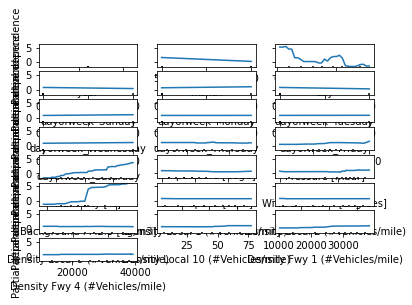

In [18]:
display = PartialDependenceDisplay.from_estimator(
    gbt_model_loo,
    X=site_train_x,
    features=nLoop(dtk.df_getColNames(site_train_x)),
    feature_names=dtk.df_getColNames(site_train_x),
    verbose=True,
    n_jobs=PARALLEL_CORES,
    method='auto',
    kind='average',
    random_state=RANDOM_STATE,
    grid_resolution=150,
    subsample=0.1
)

In [19]:
partial_fig = []
partial_ax = []
for n in nLoop(dtk.df_getColNames(site_train_x)):
    fig, ax = plt.subplots(dpi=300)
    plt.close(fig)
    partial_fig.append(fig)
    partial_ax.append(ax)
display.plot(ax=partial_ax)

In [20]:

full_partial_fig, full_partial_ax = plt.subplots(nrows=11, ncols=2, dpi=300, figsize=(22, 44))
display.plot(ax=full_partial_ax)


def activate_grid(x):
    x.grid(linestyle=':')


activate_grid_v = np.vectorize(activate_grid)
activate_grid_v(full_partial_ax)
full_partial_fig.savefig(FolderPath_graphs + f'/{y_var}_full_partial_dependence.png', dpi=300, facecolor='white',
                         edgecolor='azure')
full_partial_fig

In [21]:
partial_feats = dtk.df_getColNames(site_train_x)

for i in nLoop(partial_fig):
    partial_fig[i].suptitle(f'Partial Dependence - {partial_feats[i]}')
    partial_ax[i].grid(linestyle=':')
    partial_fig[i].savefig(
        FolderPath_graphs + f'/partial_dependence/{y_var}_partial_dependence_{feat_filenames[i]}.png',
        dpi=300,
        facecolor='white', edgecolor='azure')